# Imports

In [1]:
import sys
import copy
import numpy as np
from model.base import CovidModel, SimulationParameters, set_parameters, normal_ci
from utils import BasicStatistics, AddPolicy, RemovePolicy, Propaganda, setup_city_layout, AddPolicyInfectedRate, confidence_interval, multiple_runs
from model.utils import SocialPolicy
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import timedelta

## Real Data

### NYTimes Dataset

In [2]:
# os.listdir('./data')
us_counties = pd.read_csv("./data/us-counties.csv")

us_counties.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [3]:
us_counties = us_counties.loc[(us_counties.county == 'Greene') & (us_counties.state == 'Missouri')]
us_counties.index = pd.to_datetime(us_counties['date'])
assert sum(us_counties.fips == 29077.0) == us_counties.shape[0]
us_counties.drop(columns=['county', 'state', 'date', 'fips'], inplace=True)
us_counties.head()

,cases,deaths
date,,
2020-03-12,1,0.0
2020-03-13,1,0.0
2020-03-14,2,0.0
2020-03-15,2,0.0
2020-03-16,3,0.0


<AxesSubplot:xlabel='date'>

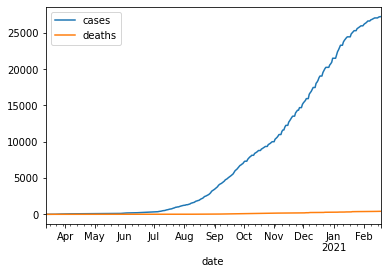

In [4]:
us_counties.plot()

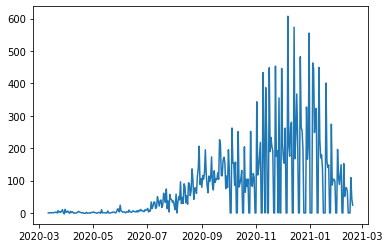

In [5]:
us_counties['daily_cases'] = np.concatenate(([0], us_counties.cases[1:].values - us_counties.cases[:-1].values))
plt.plot(us_counties.daily_cases)

<AxesSubplot:xlabel='date'>

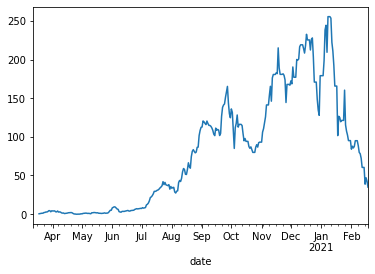

In [6]:
us_counties['mean_daily_cases'] = us_counties['daily_cases'].rolling(7).mean()
us_counties.mean_daily_cases.plot()

# Simulation

## Greene LockDown Parameters

In [7]:
start_date = us_counties.iloc[0]._name

Phase 0: mar 26 - may 3
   - Stay at home order (severe lockdown)
   - Private schools closed
   
Phase 1: may 4 - may 22
   - Either "max 25% occupancy" or "no more than 25 people allowed"
   - Private schools closed

Phase 2: may 23 - jun 14
   - Public gatherings from max 25 people to max 25% occupancy
   - Private schools closed

Phase 3: jun 15 - jul 15
   - Most occupancy limits went to 50%. Public gatherings remained at 25%.
   - Private schools may reopen (assumes public schools are reopened across the state in June)

Phase 3a: jul 16 - oct 11
   - Most occupancy limits went to 50%. Public gatherings remained at 25%.
   - Private schools open

Phase 3b: oct 12 - jan 9 2021
   - Most occupancy limits went to 50% (including public gatherings).
   - Private schools open


In [8]:
s = pd.to_datetime(
    pd.Series(['3/26/2020', 
               '5/4/2020', 
               '5/23/2020', 
               '6/15/2020', 
               '7/16/2020', 
               '10/12/2020', 
               #'1/10/2021'
              ]))

In [9]:
abs_dates = s - start_date
dates_df = pd.DataFrame(s)
dates_df['phase'] = ['0', '1', '2', '3', '3a','3b', 
                     #'4'
                    ]
dates_df['num_days'] = abs_dates.apply(lambda x: int(x.days))
dates_df.columns = ['date', 'phase', 'num_days']

In [10]:
dates_df

,date,phase,num_days
0,2020-03-26,0,14
1,2020-05-04,1,53
2,2020-05-23,2,72
3,2020-06-15,3,95
4,2020-07-16,3a,126
5,2020-10-12,3b,214


In [11]:
START = 0
PHASE_0 = 14
PHASE_1 = 53
PHASE_2 = 72
PHASE_3 = 95
PHASE_3a = 126
PHASE_3b = 214

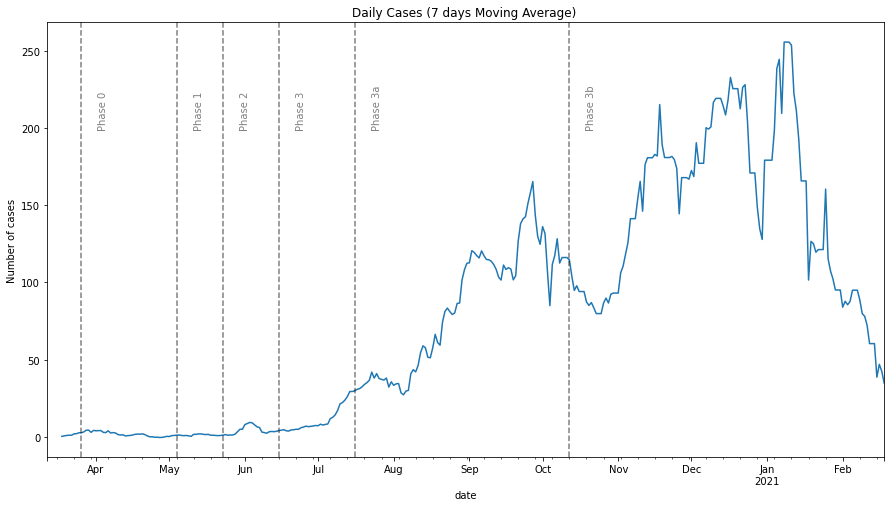

In [12]:
delta = timedelta(days=7)

us_counties.mean_daily_cases.plot(figsize=(15, 8))
plt.title("Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 200, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

In [13]:
us_counties.dropna(inplace=True)
us_counties.index.min()

Timestamp('2020-03-18 00:00:00')

In [14]:
num_days = us_counties.index.max() - us_counties.index.min()
num_days = num_days.days + 1

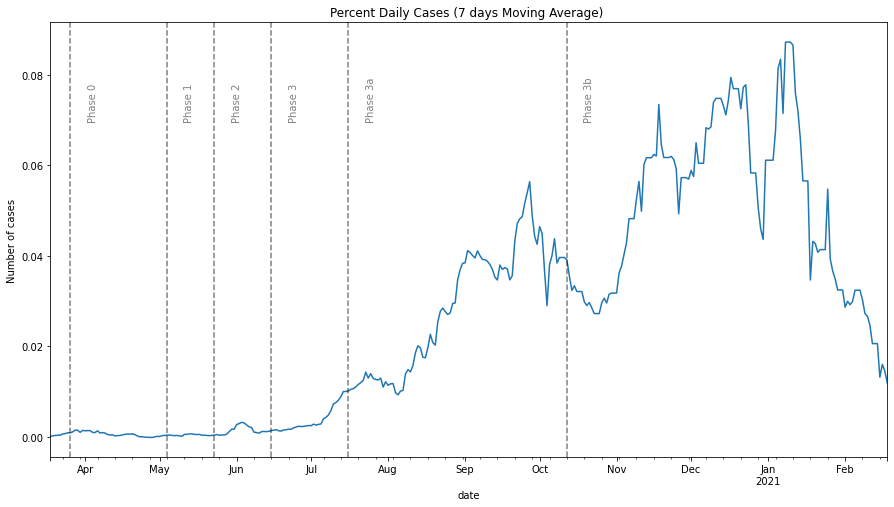

In [15]:
greene_population = 293086

us_counties['percent_daily_cases'] = np.round(100 * us_counties.mean_daily_cases/greene_population, 5)
us_counties['percent_daily_cases'].plot(figsize=(15, 8))
plt.title("Percent Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.07, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

## Parameters settings

In [19]:
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_RETAIL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_FACTORY, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_OFFICE, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, START],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, PHASE_3],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, PHASE_3],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_FACTORY, PHASE_3a],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_OFFICE, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, PHASE_3b],
]

In [20]:
common_parameters = SimulationParameters(
    mask_user_rate = 0.9,
    mask_efficacy = 0.6,
    imune_rate = 0.01,
    initial_infection_rate = 0.0005,
    hospitalization_capacity = 0.05,
    latency_period_shape = 3,
    latency_period_scale = 1, 
    incubation_period_shape = 6,
    incubation_period_scale = 1, 
    mild_period_duration_shape = 14,
    mild_period_duration_scale = 1,
    hospitalization_period_duration_shape = 12,
    hospitalization_period_duration_scale = 1,
    symptomatic_isolation_rate = 0.0,
    asymptomatic_contagion_probability = 0.1,
#    asymptomatic_contagion_probability = 0.05,
#     risk_tolerance_mean = 0.7,
    risk_tolerance_mean = 0.2,
    risk_tolerance_stdev = 0.2,
    herding_behavior_mean = 0.7,
#    herding_behavior_mean = 0.1,
    herding_behavior_stdev = 0.2,
    allowed_restaurant_capacity = 0.25, #1.0, # valid values: {1.0, 0.50, 0.25}
    spreading_rate = normal_ci(2.41, 3.90, 20)
#    spreading_rate = normal_ci(0.5, 1.5, 20)
)

sc = 10

population_size = 1500
simulation_cycles = num_days # days
seed = 31415
np.random.seed(seed)

params = copy.deepcopy(common_parameters)

In [21]:
greene_demographics = {
    'total_population': 293086,
    'age_distribution':{
        4: 6.0,
        9: 5.7,
        14: 5.8,
        19: 6.5,
        24: 10.6,
        34: 14.1,
        44: 11.7,
        54: 11.5,
        59: 6.0,
        64: 6.0,
        74: 8.9,
        84: 5.0,
        100: 2.1
    },
    #'work_classes':{
    #    'Retail': 12.7,
    #}
}

Save these seeds if you want to rerun a scenario
[9675]
log initialized
Average similarity between family members is 0.9998936824522031 at temperature -1
Average similarity between family and home is 0.9998860296422398 at temperature -1
Average similarity between students and their classroom is 0.9998548785029053 at temperature -1
Average classroom occupancy is 6.041095890410959 and number classrooms is 73
Average similarity between workers is 0.9998853414884615 at temperature -1
Average office occupancy is 3.967871485943775 and number offices is 249
Average friend similarity for adults: 0.9998669126617399 for kids: 0.9998476491207731
home_districts
[
Home (0,0) district with 30 Buildings
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 18 allocated units with a total of 54 people.
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 19 allocated units with a total of 51 people.
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 19 allocated un

avg restaurant similarity 0.9995234401497108
avg restaurant similarity 0.9996055258890699
avg restaurant similarity 0.9997620077092503
avg restaurant similarity 0.9997412816304454
avg restaurant similarity 0.9997753648035764
avg restaurant similarity 0.9995628062826092
avg restaurant similarity 0.9997279512329333
avg restaurant similarity 0.9996593523202035
avg restaurant similarity 0.9997007794911994
avg restaurant similarity 0.9995944913810315
avg restaurant similarity 0.9996726978387653
avg restaurant similarity 0.9996185642592847
avg restaurant similarity 0.9997178538371561
avg restaurant similarity 0.9995408363163308
avg restaurant similarity 0.9995893093756972
avg restaurant similarity 0.9996707128292768
avg restaurant similarity 0.9997174269408294
avg restaurant similarity 0.9996903967628713
avg restaurant similarity 0.9996527200406048
avg restaurant similarity 0.9997088697515427
avg restaurant similarity 0.9996579457949145
avg restaurant similarity 0.9997389397670231
avg restau

avg restaurant similarity 0.9996413176045539
avg restaurant similarity 0.9996991330395633
avg restaurant similarity 0.9996663950990765
avg restaurant similarity 0.9996260322914351
avg restaurant similarity 0.9996139409768438
avg restaurant similarity 0.9995949954411847
avg restaurant similarity 0.9996154530953326
avg restaurant similarity 0.9996677331836924
avg restaurant similarity 0.9996282298974595
avg restaurant similarity 0.9996218728798966
avg restaurant similarity 0.9997217368709159
avg restaurant similarity 0.9995999861727342
avg restaurant similarity 0.9997095207777463
avg restaurant similarity 0.9996570736034305
avg restaurant similarity 0.9997347806191583
avg restaurant similarity 0.9996985449559639
avg restaurant similarity 0.9997687679046446
avg restaurant similarity 0.9996591307664372
avg restaurant similarity 0.9998065171924697
avg restaurant similarity 0.9996922800148795
avg restaurant similarity 0.9997148167890644
avg restaurant similarity 0.9997532269260742
avg restau

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


using average of time series:
stats on susceptible:
data: [0.7580197238658776]
min:
0.7580197238658776
max:
0.7580197238658776
std:
0.0
mean:
0.7580197238658776
median:
0.7580197238658776
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats on infected:
data: [0.04135305719921104]
min:
0.04135305719921104
max:
0.04135305719921104
std:
0.0
mean:
0.04135305719921104
median:
0.04135305719921104
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats on recovered:
data: [0.18570611439842208]
min:
0.18570611439842208
max:
0.18570611439842208
std:
0.0
mean:
0.18570611439842208
median:
0.18570611439842208
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats on hospitalization:
data: [0.005899408284023668]
min:
0.005899408284023668
max:
0.005899408284023668
std:
0.0
mean:
0.005899408284023668
median:
0.005899408284023668
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats o

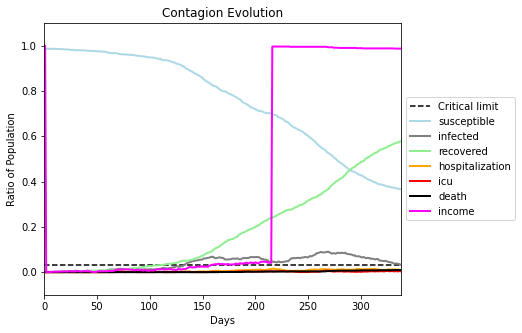

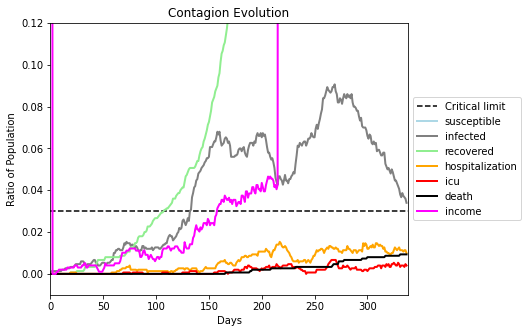

In [22]:
import logging
def setLevel(level):
    logger1 = logging.getLogger()
    logger1.setLevel(level)

seeds = [9675]
#seeds = [14568, 31221, 63168, 76414, 65369, 15407,  6812, 85182, 17096,
#         50499,  5681, 24521, 34752, 91576, 91228, 69453,  2126, 83567,
#         1565, 14436]
setLevel(logging.CRITICAL)
lower, average, upper, color, statistics, avg,  last,  peak = multiple_runs(
    params,
    population_size,
    simulation_cycles,
    seeds = seeds,
    fname = "ramon",
    do_print = True, 
    desired_stats = ["susceptible", "infected", "recovered", "hospitalization", "icu", "death", "income"],
    listeners = listeners,
    demographics = greene_demographics
)

In [23]:
infected_df = pd.DataFrame(
    {'lower': lower['infected'],
    'average': average['infected'],
    'upper': upper['infected']}
)
infected_df.index = us_counties.index

Text(2021-01-01 00:00:00, nan, 'Christmas')

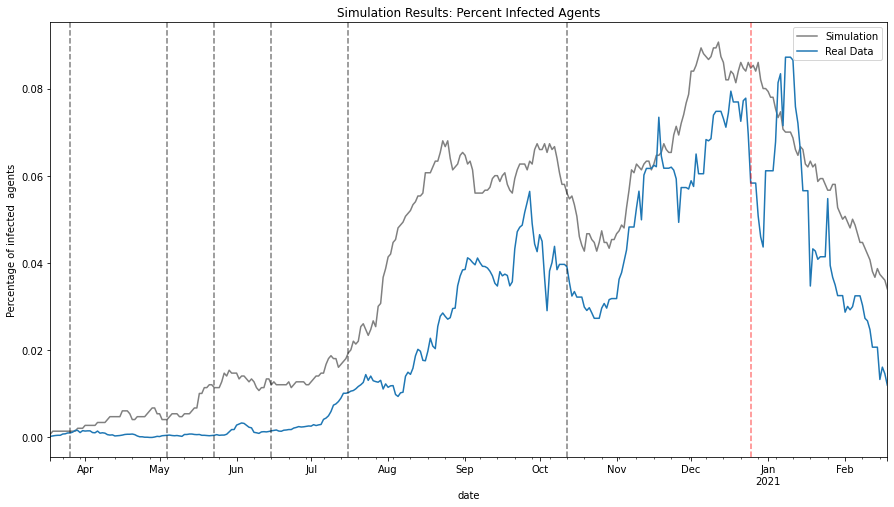

In [24]:
stat = 'infected'
fig, ax = plt.subplots(figsize=(15,8))
infected_df.average.plot(ax = ax, color=color[stat])
us_counties['percent_daily_cases'].plot(ax=ax)
ax.plot(infected_df.index, infected_df.upper, color=color[stat], linewidth=.3)
ax.plot(infected_df.index, infected_df.lower, color=color[stat], linewidth=.3) #mean curve.
ax.fill_between(infected_df.index, infected_df.lower, infected_df.upper, color=color[stat], alpha=.1) #std curves.



plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(infected_df['upper']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

CHRISTMAS = pd.to_datetime('25-12-2020')
plt.axvline(CHRISTMAS, color='red', linestyle='--', alpha=0.5)
plt.text(CHRISTMAS + delta, 0.9 * np.max(infected_df['upper']), 'Christmas', color='red', rotation=90, alpha = 0.5)